

* This dataset consists of 1 Million+ transaction by over 800K customers for a bank in India.
* The data contains information such as - customer age (DOB), location, gender, account balance at the time of the transaction , transactiondetails,transaction amount, etc.  

# Objective of this project:

1. Perform Clustering / Segmentation on the dataset and identify popular customer groups along with their definitions/rules
2. Perform Location-wise analysis to identify regional trends in India
3. Perform transaction-related analysis to identify interesting trends that can be used by a bank to improve / optimi their user experiences
4. Customer Recency, Frequency, Monetary analysis
5. Network analysis or Graph analysis of customer data.

**Table of contents of this notebook:**

1. Importing Necessary Libraries

2. Data Collection

3. Data Cleaning

4. Exploratory Data Analysis

5. Feature Engineering

6. Modelling

7. Classification Problem

8. Modelling for Classification

### 1. Importing Necessary Libraries

In [70]:
pip install kneed


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

#import regex as re
import plotly.express as px
from datetime import timedelta
import plotly.graph_objects as go
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from kneed import KneeLocator



### 2. Data Collection

In [72]:
df=pd.read_csv("bank_transaction.csv")
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [73]:
df.shape

(1048567, 9)

wow, the shape of the data is very big 😵😵

### 3. Data Cleaning

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [75]:
## Show detailes data set
def check(df):
    l=[]
    columns=df.columns
    for col in columns:
        dtypes=df[col].dtypes
        nunique=df[col].nunique()
        sum_null=df[col].isnull().sum()
        l.append([col,dtypes,nunique,sum_null])
    df_check=pd.DataFrame(l)
    df_check.columns=['column','dtypes','nunique','sum_null']
    return df_check
check(df)

,column,dtypes,nunique,sum_null
0,TransactionID,object,1048567,0
1,CustomerID,object,884265,0
2,CustomerDOB,object,17254,3397
3,CustGender,object,3,1100
4,CustLocation,object,9355,151
5,CustAccountBalance,float64,161328,2369
6,TransactionDate,object,55,0
7,TransactionTime,int64,81918,0
8,TransactionAmount (INR),float64,93024,0


In [76]:
# delete missing data
df.dropna(inplace=True)

In [77]:
#check for duplication
df.duplicated().sum()

0

In [78]:
# convert type of columns TransactionDate,CustomerDOB from string to datetime
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'])

C:\Users\linco\AppData\Local\Temp\ipykernel_3024\276658000.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\linco\AppData\Local\Temp\ipykernel_3024\276658000.py:3: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



<p> calculate customer age :</p>
<p> CustomerDOB is the birth date of the customer , TransactionDate : is the date of transaction that customer is done
</p>

In [79]:
df['CustomerAge'] =df['TransactionDate'].dt.year - df['CustomerDOB'].dt.year

I'm going to get rid of TransactionTime since I'm uncertain about what it refers to, specifically which days, hours, or minutes are encompassed in it. 🤷‍

In [80]:
df.drop(columns=['TransactionTime'],inplace=True)

In [81]:
df.CustGender.value_counts()

CustGender
M    760978
F    280635
T         1
Name: count, dtype: int64

In [82]:
# dropping df.CustGender.value == 'T'
df.drop(df[df['CustGender'] == 'T'].index, inplace = True)

In [83]:
df.CustGender.value_counts()

CustGender
M    760978
F    280635
Name: count, dtype: int64

Now the data is cleaned and I will perform RFM on it.

<img src="https://miro.medium.com/max/638/0*JddVeZpHXdElEec_" alt="RFM" >

<p>Recency: number of days since the last purchase or order so I will create a new column of TransactionDate to subtract the last transaction from the first transaction</p>

In [84]:
snapshot_date = df['TransactionDate'].max() + timedelta(days=1)

In [85]:
df['TransactionDate1']=df['TransactionDate']

In [86]:
#Creating MRF Table Strategy

RFM_df = df.groupby("CustomerID").agg({ "TransactionID" : "count",     # TransactionID = Frequency
                                        "CustGender" : "first",
                                        "CustLocation":"first",
                                        "CustAccountBalance"  : "mean",
                                        "TransactionAmount (INR)" : "sum",   # TransactionAmount (INR) = Monetary
                                        "CustomerAge" : "median",
                                        "TransactionDate":lambda x: (snapshot_date - x.max()).days,
                                        'TransactionDate1':"median"
      })

RFM_df = RFM_df.reset_index()
RFM_df.head()

,CustomerID,TransactionID,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate,TransactionDate1
0,C1010011,2,F,NOIDA,76340.635,5106.0,28.5,75,2016-09-17
1,C1010012,1,M,MUMBAI,24204.490,1499.0,22.0,118,2016-08-14
2,C1010014,2,F,MUMBAI,100112.950,1455.0,28.0,155,2016-04-08
3,C1010018,1,F,CHAMPARAN,496.180,30.0,26.0,86,2016-09-15
4,C1010024,1,M,KOLKATA,87058.650,5000.0,-49.0,114,2016-08-18


In [87]:
RFM_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879357 entries, 0 to 879356
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CustomerID               879357 non-null  object        
 1   TransactionID            879357 non-null  int64         
 2   CustGender               879357 non-null  object        
 3   CustLocation             879357 non-null  object        
 4   CustAccountBalance       879357 non-null  float64       
 5   TransactionAmount (INR)  879357 non-null  float64       
 6   CustomerAge              879357 non-null  float64       
 7   TransactionDate          879357 non-null  int64         
 8   TransactionDate1         879357 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 60.4+ MB


In [88]:
RFM_df.shape

(879357, 9)

In [89]:
RFM_df.drop(columns=["CustomerID"],inplace=True)

In [90]:
RFM_df.rename(columns={"TransactionID":"Frequency","TransactionAmount (INR)":"Monetary","TransactionDate":"Recency", 'TransactionDate1':"TransactionDate" },inplace=True)

In [91]:
RFM_df

,Frequency,CustGender,CustLocation,CustAccountBalance,Monetary,CustomerAge,Recency,TransactionDate
0,2,F,NOIDA,76340.635,5106.0,28.5,75,2016-09-17
1,1,M,MUMBAI,24204.490,1499.0,22.0,118,2016-08-14
2,2,F,MUMBAI,100112.950,1455.0,28.0,155,2016-04-08
3,1,F,CHAMPARAN,496.180,30.0,26.0,86,2016-09-15
4,1,M,KOLKATA,87058.650,5000.0,-49.0,114,2016-08-18
...,...,...,...,...,...,...,...,...
879352,1,M,BHIWANDI,133067.230,691.0,26.0,155,2016-07-08
879353,1,M,BANGALORE,96063.460,222.0,20.0,86,2016-09-15
879354,1,M,GUNTUR,5559.750,126.0,23.0,114,2016-08-18
879355,1,M,CHENNAI,35295.920,50.0,21.0,104,2016-08-28


<h2  style="color:darkmagenta;text-align: center; background-color: AliceBlue;padding: 20px;">4. Exploratory Data Analysis</h2><a id = "4"></a>

In [92]:
RFM_df.describe()

,Frequency,CustAccountBalance,Monetary,CustomerAge,Recency,TransactionDate
count,879357.000000,8.793570e+05,8.793570e+05,879357.000000,879357.000000,879357
mean,1.184517,1.147151e+05,1.855032e+03,31.928997,129.791716,2016-07-26 00:35:32.299851008
min,1.000000,0.000000e+00,0.000000e+00,-57.000000,1.000000,2016-01-08 00:00:00
25%,1.000000,5.591270e+03,2.000000e+02,24.000000,87.000000,2016-06-09 00:00:00
50%,1.000000,1.866578e+04,5.330000e+02,28.000000,110.000000,2016-08-19 00:00:00
75%,1.000000,6.154197e+04,1.500000e+03,33.000000,154.000000,2016-09-09 00:00:00
max,6.000000,1.150355e+08,1.560035e+06,216.000000,337.000000,2016-12-09 00:00:00
std,0.448954,8.010842e+05,7.188245e+03,47.339366,80.051009,NaN


In [93]:
num_df = RFM_df.select_dtypes(include=np.number)
num_df

,Frequency,CustAccountBalance,Monetary,CustomerAge,Recency
0,2,76340.635,5106.0,28.5,75
1,1,24204.490,1499.0,22.0,118
2,2,100112.950,1455.0,28.0,155
3,1,496.180,30.0,26.0,86
4,1,87058.650,5000.0,-49.0,114
...,...,...,...,...,...
879352,1,133067.230,691.0,26.0,155
879353,1,96063.460,222.0,20.0,86
879354,1,5559.750,126.0,23.0,114
879355,1,35295.920,50.0,21.0,104


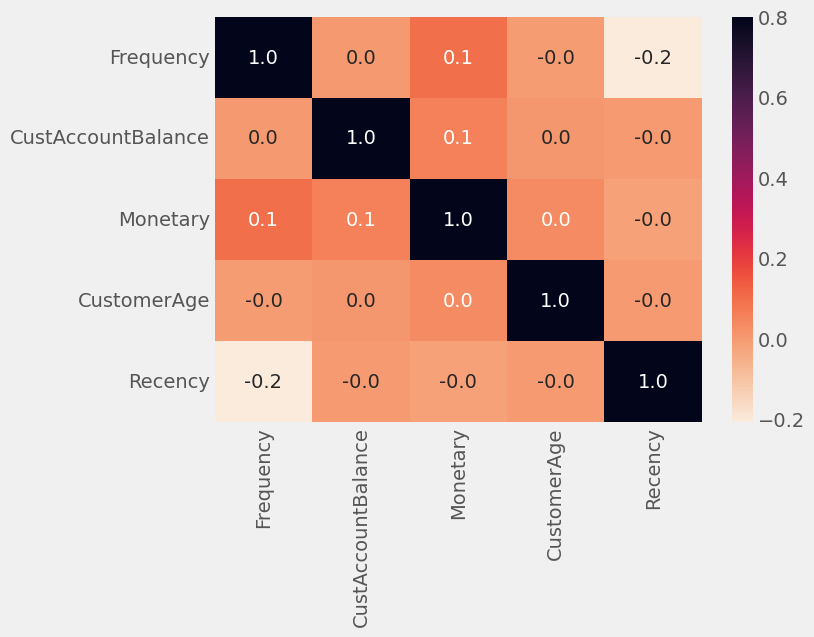

In [94]:
# correlation between features
plt.figure(figsize=(7,5))
sns.heatmap(num_df.corr(),vmin=None,
    vmax=0.8,
    cmap='rocket_r',
    annot=True,
    fmt='.1f',
    linecolor='white',
    cbar=True);

C:\Users\linco\AppData\Local\Temp\ipykernel_3024\3692345101.py:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


c:\Program Files\Python310\lib\site-packages\seaborn\distributions.py:2496: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


C:\Users\linco\AppData\Local\Temp\ipykernel_3024\3692345101.py:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
simil

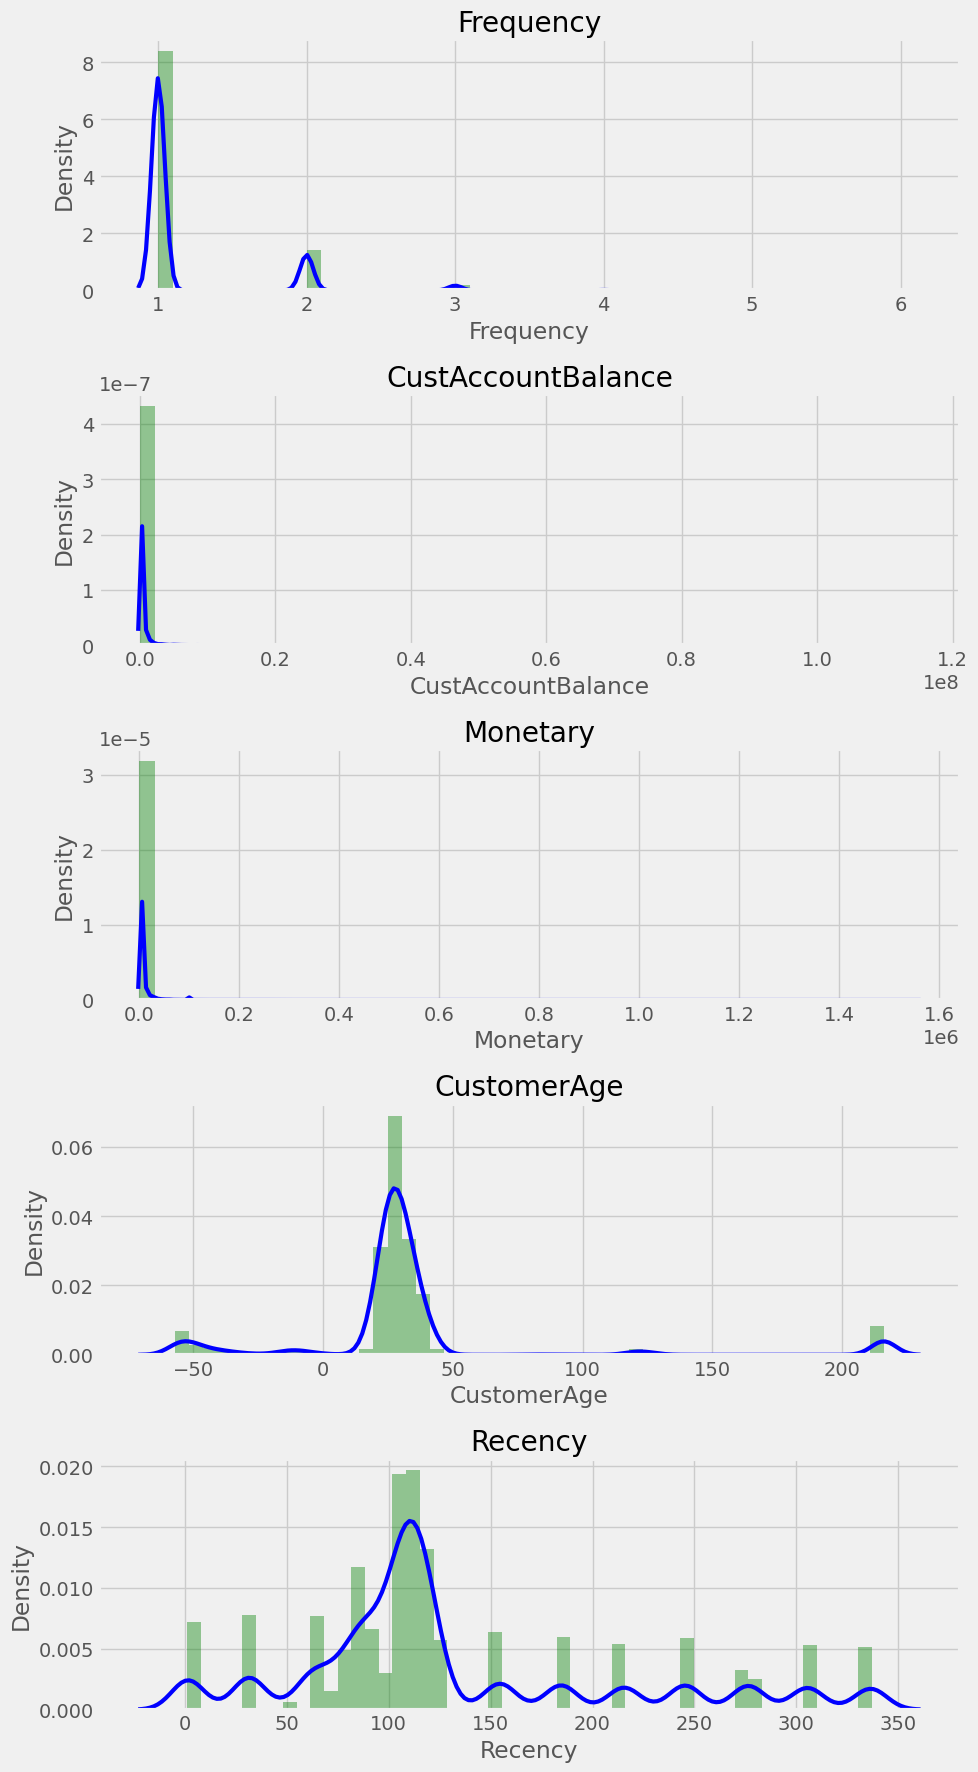

In [172]:
plt.figure(figsize=(10,60))
for i in range(0,5):
    plt.subplot(17,1,i+1)
    sns.distplot(num_df[num_df.columns[i]],kde_kws={'color':'b','bw': 0.1,'lw':3,'label':'KDE'},hist_kws={'color':'g'})
    plt.title(num_df.columns[i])
plt.tight_layout()

In [96]:
#plt.style.use("fivethirtyeight")
#sns.pairplot(MRF_df,hue='Frequency');

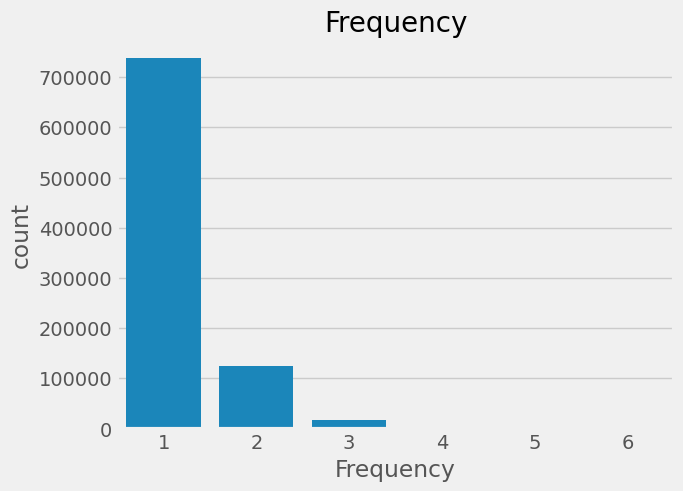

In [97]:

chart=sns.countplot(x='Frequency',data=RFM_df, order = RFM_df['Frequency'].value_counts().index)
plt.title("Frequency",fontsize='20');

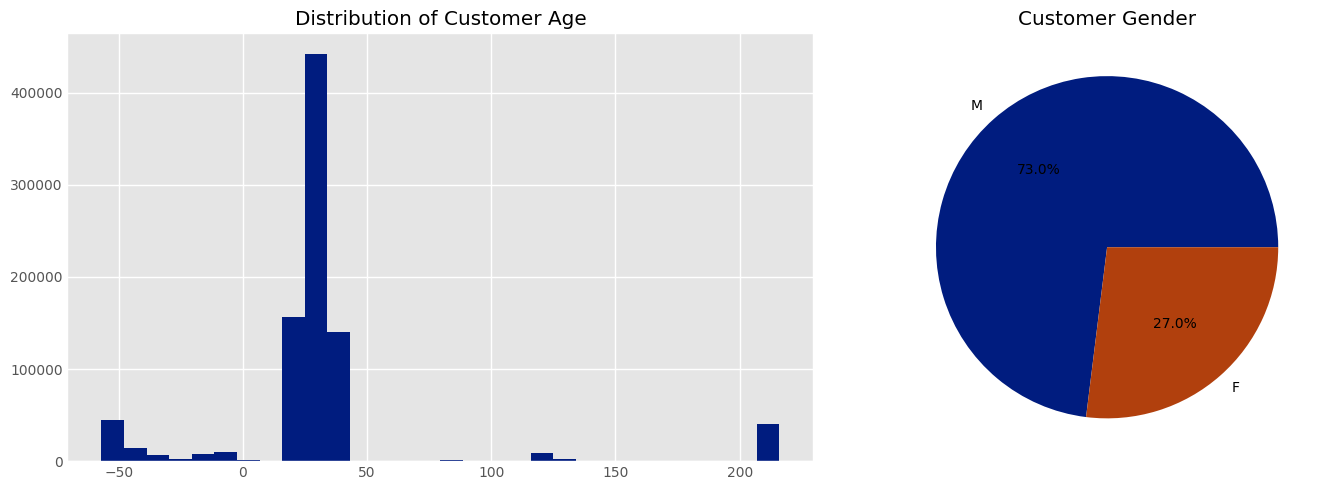

In [98]:
plt.style.use("ggplot")

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
palette_color = sns.color_palette('dark')

# Plot the histogram in the first subplot
ax[0].hist(x=RFM_df['CustomerAge'], bins=30, color=palette_color[0])
ax[0].set_title("Distribution of Customer Age")

# Plot the pie chart in the second subplot
gender_counts = RFM_df['CustGender'].value_counts()
ax[1].pie(gender_counts, autopct='%1.1f%%', colors=palette_color, labels=gender_counts.index)
ax[1].set_title("Customer Gender")

plt.tight_layout()
plt.show()


C:\Users\linco\AppData\Local\Temp\ipykernel_3024\657471999.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




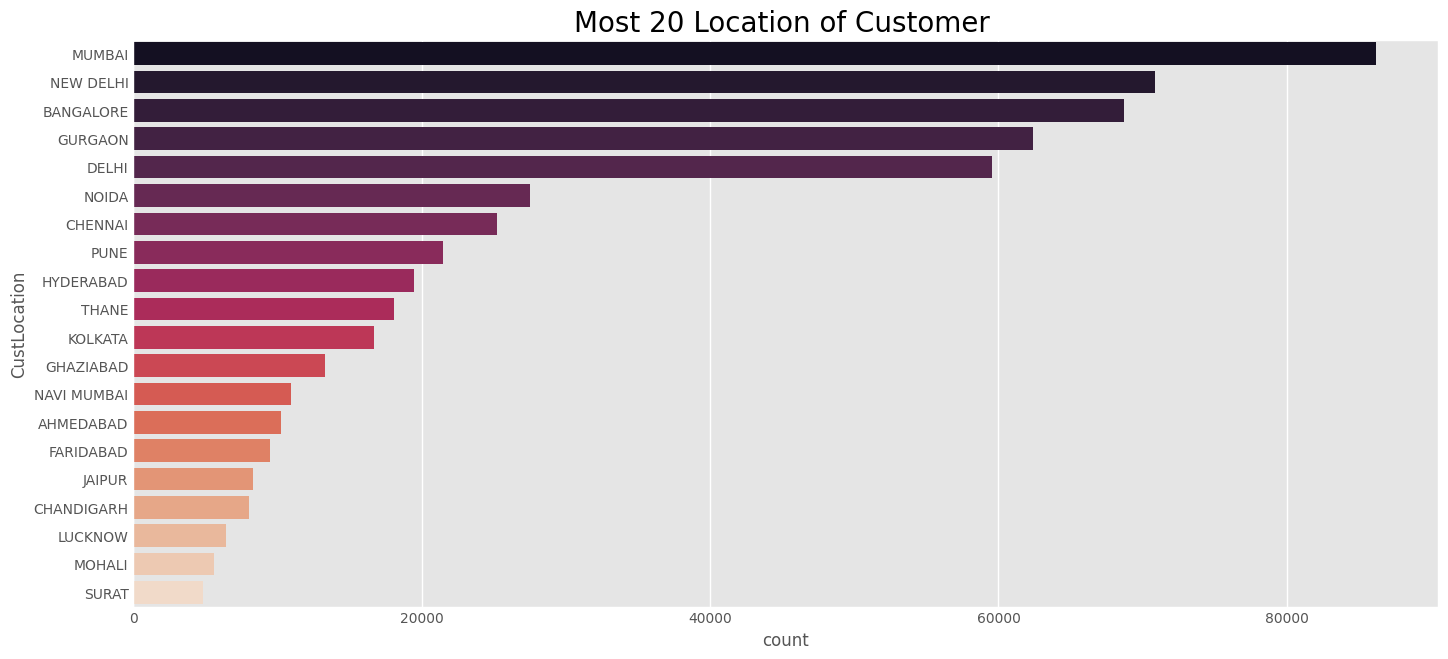

In [99]:
plt.style.use("ggplot")
plt.figure(figsize=(15,7))
chart=sns.countplot(y='CustLocation',data=RFM_df,palette='rocket', order = RFM_df['CustLocation'].value_counts()[:20].index)
plt.title("Most 20 Location of Customer ",fontsize='20');

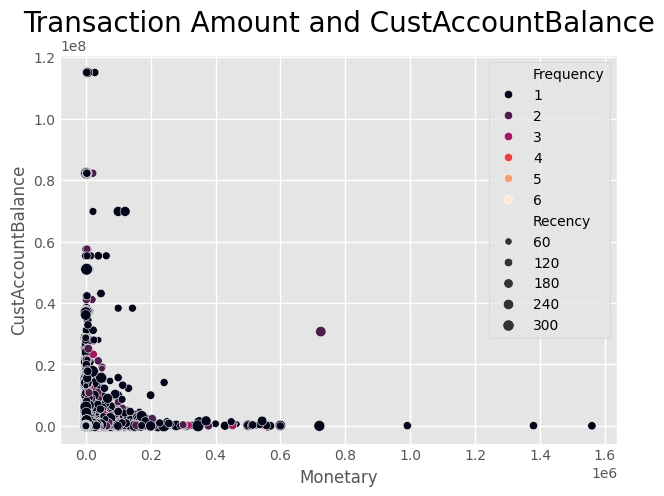

In [100]:
#plt.style.use("fivethirtyeight")
sns.scatterplot(x='Monetary',y='CustAccountBalance',data=RFM_df,palette='rocket',hue='Frequency',size='Recency' )
plt.title("Transaction Amount and CustAccountBalance",fontsize='20');

In [101]:
# Assuming 'NonNumericColumn' is a non-numeric column you want to exclude
numeric_columns = RFM_df.select_dtypes(include=['float64', 'int64']).columns

# Sort DataFrame by 'TransactionDate'
RFM_df = RFM_df.sort_values(by='TransactionDate')

# Group by month and calculate mean for numeric columns
groupby_month = RFM_df.groupby([pd.Grouper(key='TransactionDate', freq='M')])[numeric_columns].mean()

# Print the shape of the resulting DataFrame
print(groupby_month.shape)

# Display the resulting DataFrame
groupby_month



(12, 5)


,Frequency,CustAccountBalance,Monetary,CustomerAge,Recency
TransactionDate,,,,,
2016-01-31,1.025196,107508.805797,1489.648345,32.260653,335.540285
2016-02-29,1.064317,105680.497569,1607.304006,32.496170,302.393473
2016-03-31,1.091612,111479.999592,1789.225307,31.595601,271.234251
2016-04-30,1.172430,114318.492265,1958.528625,30.694105,230.895996
2016-05-31,1.355424,109561.572298,2152.916186,31.624119,181.231638
2016-06-30,1.359702,109571.765181,2239.689499,31.364042,155.630599
2016-07-31,1.354797,106349.124901,2139.698327,30.918318,134.148650
2016-08-31,1.158752,120503.189601,1817.518125,32.177685,109.317667
2016-09-30,1.211712,117934.764734,1854.453381,32.545225,81.304342


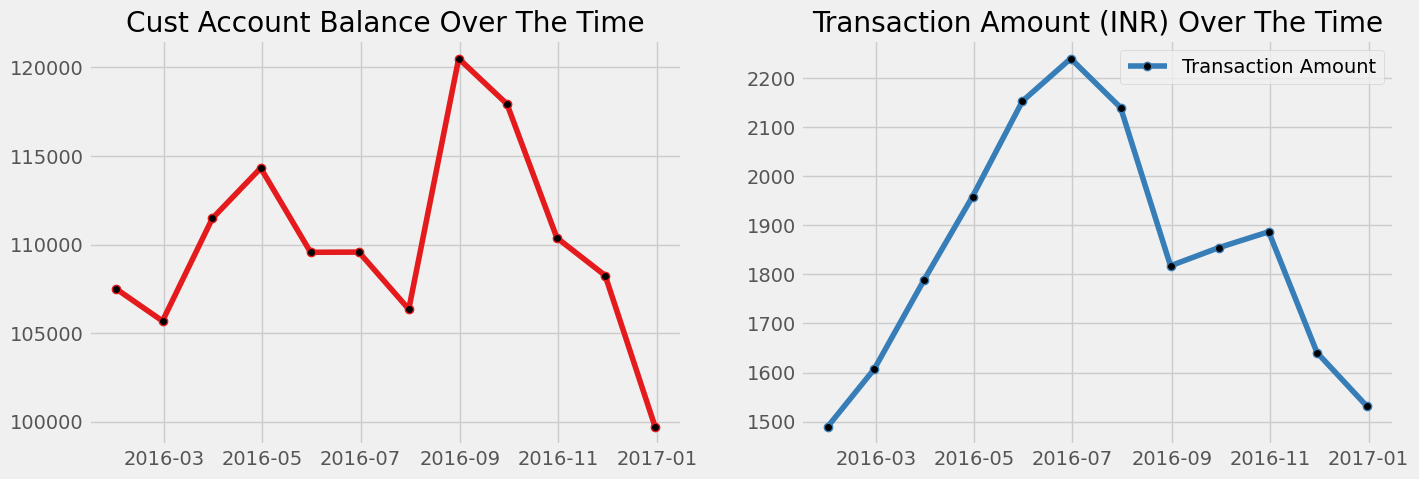

In [102]:
# Assume you have a color palette with different colors
custom_palette = sns.color_palette('Set1', n_colors=2)

plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

# Plotting the first subplot with different color for markers
ax[0].plot(groupby_month.index, groupby_month['CustAccountBalance'], marker='o', linestyle='-', color=custom_palette[0], label='Customer Account Balance', markerfacecolor='black', markeredgecolor=custom_palette[0])
ax[0].set_title('Cust Account Balance Over The Time')

# Plotting the second subplot with a different color for markers
ax[1].plot(groupby_month.index, groupby_month['Monetary'], marker='o', linestyle='-', color=custom_palette[1], label='Transaction Amount', markerfacecolor='black', markeredgecolor=custom_palette[1])
ax[1].set_title("Transaction Amount (INR) Over The Time")

plt.legend()
plt.show()



Observations from the above graph 💡:

- The average Customer Account Balance significantly decreases for the last three months of the year.
- The average Transaction Amount significantly increases for the first half of the year and then decreases over the time for the second half of the year.



<h2  style="color:darkmagenta;text-align: center; background-color: AliceBlue;padding: 20px;">5. Feature Engineering </h2><a id = "5"></a>

In [103]:
RFM_df=RFM_df.reset_index(drop=True)

In [104]:
RFM_df.head()

,Frequency,CustGender,CustLocation,CustAccountBalance,Monetary,CustomerAge,Recency,TransactionDate
0,1,F,AHMEDABAD,703891.99,2000.00,29.0,337,2016-01-08
1,1,M,MUMBAI,156310.08,1347.90,-51.0,337,2016-01-08
2,1,M,OPP SAI BABA TEMPLE HYDERABAD,95792.79,9900.00,216.0,337,2016-01-08
3,1,M,DELHI,1753.41,154.05,27.0,337,2016-01-08
4,1,M,DELHI,39579.53,194.00,30.0,337,2016-01-08


In [105]:
RFM_df.drop(columns=['CustLocation','TransactionDate'],inplace=True)

In [106]:
RFM_df['CustGender']=RFM_df['CustGender'].map({'M':1,'F':0})

In [107]:
RFM_df.drop(RFM_df[RFM_df['Recency']<=0].index,inplace=True)

In [108]:
RFM_df

,Frequency,CustGender,CustAccountBalance,Monetary,CustomerAge,Recency
0,1,0,703891.99,2000.00,29.0,337
1,1,1,156310.08,1347.90,-51.0,337
2,1,1,95792.79,9900.00,216.0,337
3,1,1,1753.41,154.05,27.0,337
4,1,1,39579.53,194.00,30.0,337
...,...,...,...,...,...,...
879352,1,1,1307.91,1058.91,25.0,1
879353,1,0,12320.47,309.63,18.0,1
879354,1,1,1304.80,50.00,24.0,1
879355,1,0,17989.61,250.00,-57.0,1


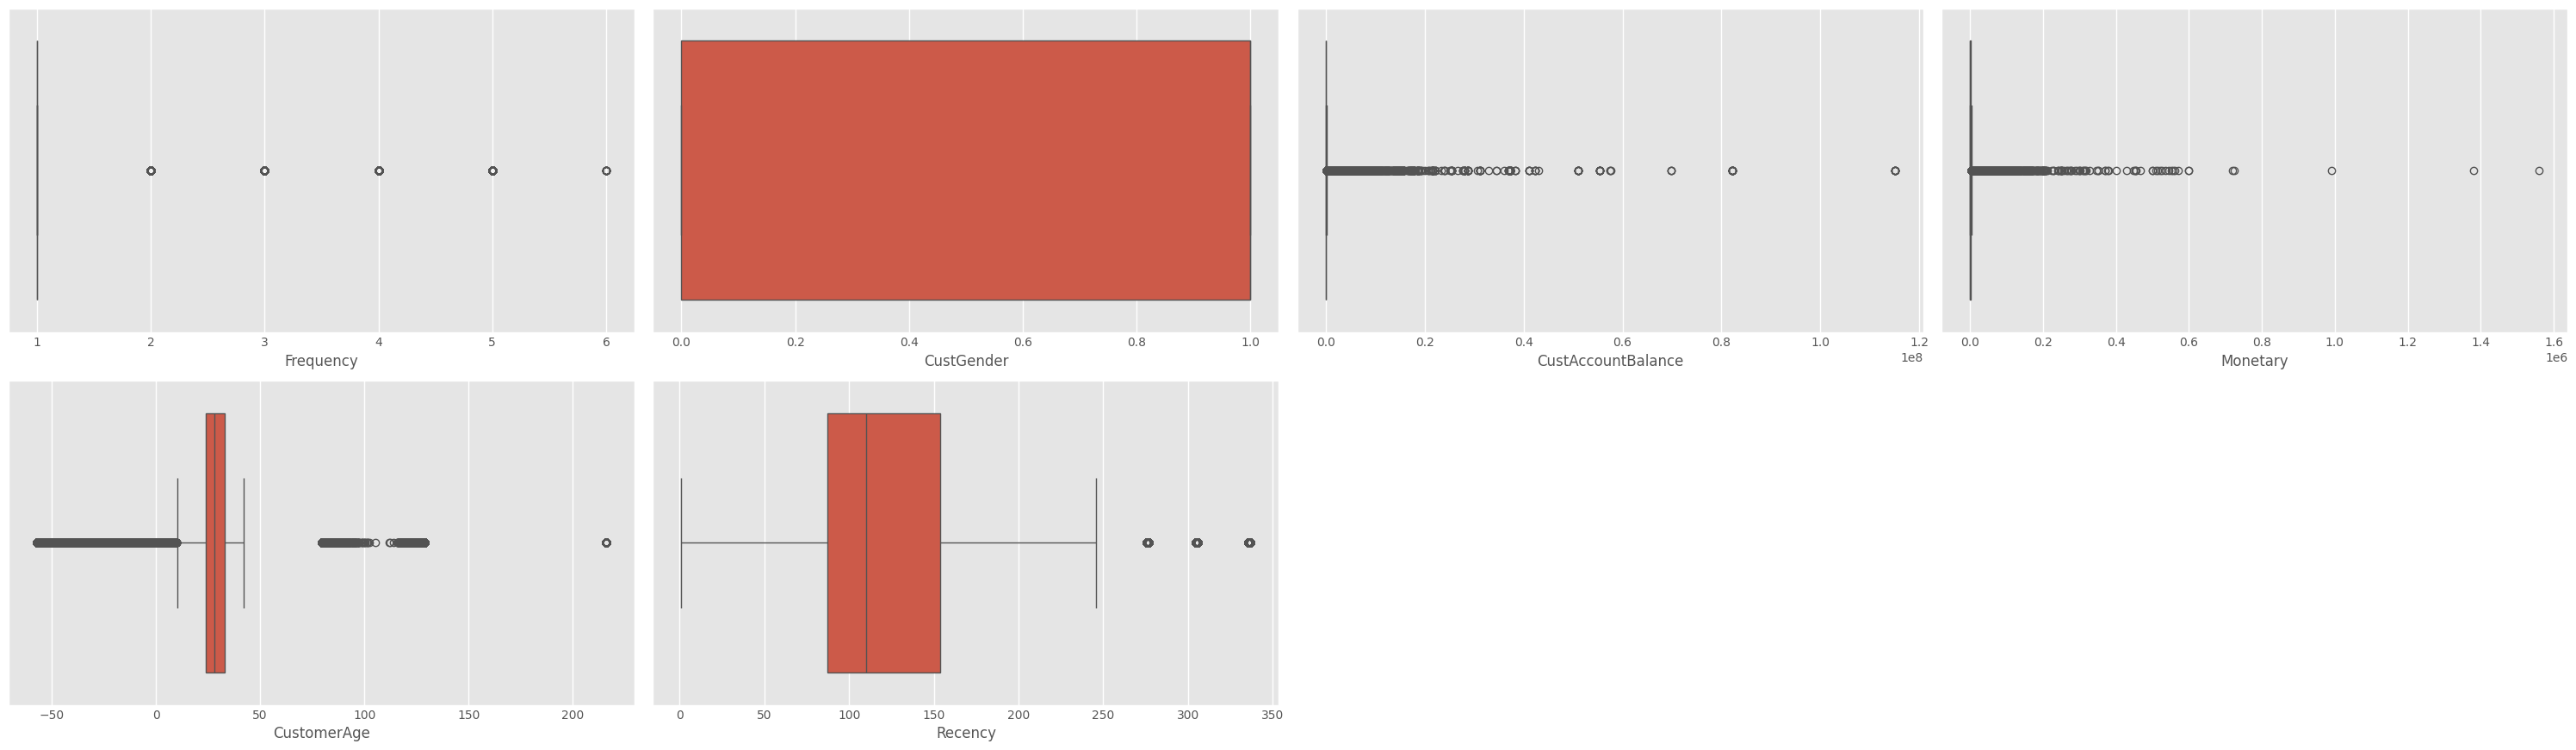

In [109]:
# checking for outliers
plt.style.use("ggplot")
plt.figure(figsize=(30,30))
for index,column in enumerate(RFM_df.columns):
    plt.subplot(7,4,index+1)
    sns.boxplot(data=RFM_df,x=column)

plt.tight_layout(pad = 1.0)

In [110]:
# Function to calculate outliers information
def get_outliers_info(column):
    q1 = RFM_df[column].quantile(0.25)
    q3 = RFM_df[column].quantile(0.75)
    iqr = q3 - q1
    lower_range = q1 - 1.5 * iqr
    upper_range = q3 + 1.5 * iqr

    outliers = RFM_df[(RFM_df[column] < lower_range) | (RFM_df[column] > upper_range)]
    num_outliers = len(outliers)
    percent_outliers = (num_outliers / len(RFM_df)) * 100

    return pd.Series({
        'lower_range': lower_range,
        'upper_range': upper_range,
        'num_outliers': num_outliers,
        'percent_outliers': percent_outliers
    })

# Create outliers_df
outliers_df = pd.DataFrame()
outliers_df['cols'] = RFM_df.columns
outliers_df = pd.concat([outliers_df, outliers_df['cols'].apply(get_outliers_info)], axis=1)

# Set index to 'cols' and display as a table
outliers_df.set_index('cols', inplace=True)
outliers_df.style.format({'lower_range': '{:.2f}', 'upper_range': '{:.2f}', 'num_outliers': '{:.0f}', 'percent_of_outliers': '{:.2f}%'})
#print(outliers_df)

,lower_range,upper_range,num_outliers,percent_outliers
cols,,,,
Frequency,1.00,1.00,141961,16.143728
CustGender,-1.50,2.50,0,0.000000
CustAccountBalance,-78334.78,145468.02,116569,13.256163
Monetary,-1750.00,3450.00,91112,10.361207
CustomerAge,10.50,46.50,139949,15.914924
Recency,-13.50,254.50,96016,10.918887


Observations 💡:
While certain variables may appear to be outliers, ultimately I chose not to exclude any data. One detail worth noting is that the reported age may have negative values. This is due to the fact that it is possible for a Life Saver youth savings account to be opened in the name of a grandchild or child.

In [111]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, Frequency to Recency
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lower_range       6 non-null      float64
 1   upper_range       6 non-null      float64
 2   num_outliers      6 non-null      float64
 3   percent_outliers  6 non-null      float64
dtypes: float64(4)
memory usage: 412.0+ bytes


In [112]:
# Function to remove outliers using IQR method
def remove_outliers_iqr(df, columns, threshold=1.5):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Columns for which you want to remove outliers

# Remove outliers using IQR method
RFM_no_outliers = remove_outliers_iqr(RFM_df, RFM_df.columns)

print("Original DataFrame:")
print(RFM_df)
print("\nDataFrame without outliers:")
print(RFM_no_outliers)


Original DataFrame:
        Frequency  CustGender  CustAccountBalance  Monetary  CustomerAge  \
0               1           0           703891.99   2000.00         29.0   
1               1           1           156310.08   1347.90        -51.0   
2               1           1            95792.79   9900.00        216.0   
3               1           1             1753.41    154.05         27.0   
4               1           1            39579.53    194.00         30.0   
...           ...         ...                 ...       ...          ...   
879352          1           1             1307.91   1058.91         25.0   
879353          1           0            12320.47    309.63         18.0   
879354          1           1             1304.80     50.00         24.0   
879355          1           0            17989.61    250.00        -57.0   
879356          1           1             3829.82   2290.00         30.0   

        Recency  
0           337  
1           337  
2           3

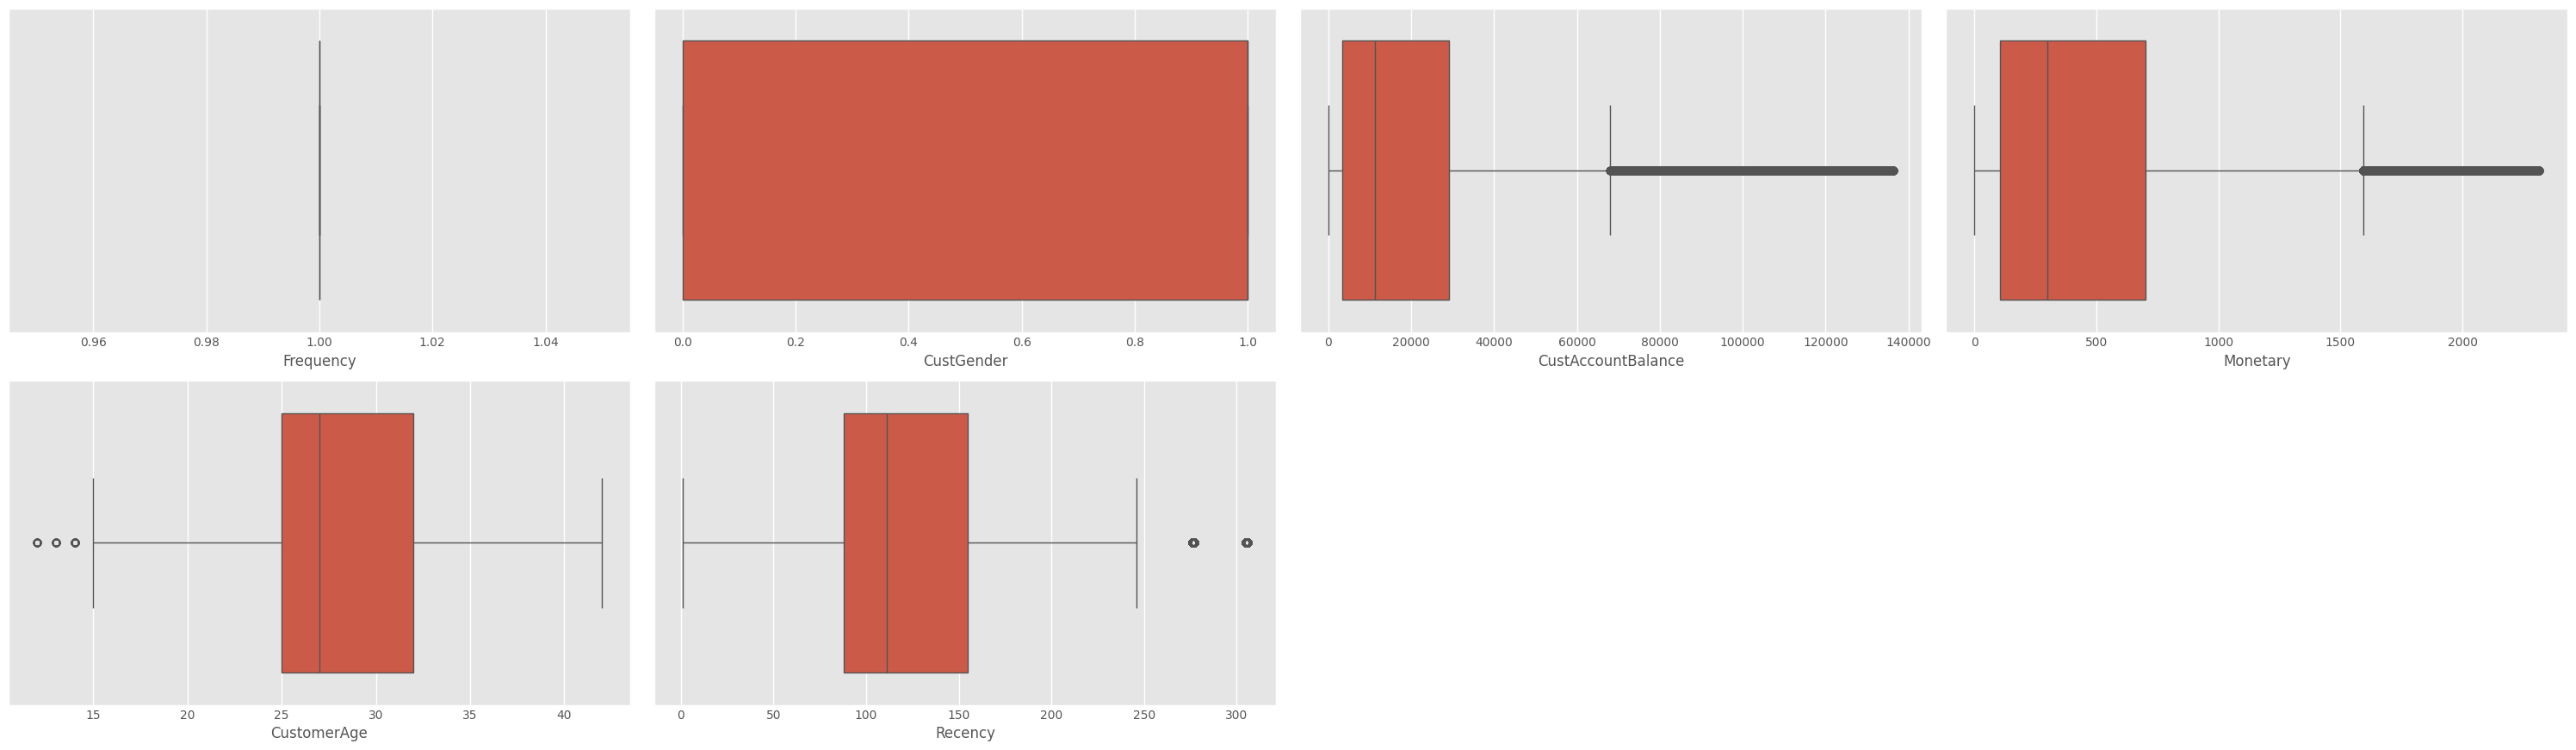

In [113]:
# checking for outliers
plt.style.use("ggplot")
plt.figure(figsize=(30,30))
for index,column in enumerate(RFM_no_outliers.columns):
    plt.subplot(7,4,index+1)
    sns.boxplot(data=RFM_no_outliers,x=column)

plt.tight_layout(pad = 1.0)

In [114]:
# data scaling
scaler = StandardScaler()
RFM_scaL=scaler.fit_transform(RFM_no_outliers)
RFM_scal=pd.DataFrame(RFM_scaL,columns=RFM_no_outliers.columns)
RFM_scal.head()

,Frequency,CustGender,CustAccountBalance,Monetary,CustomerAge,Recency
0,0.0,-1.659201,0.751183,-0.947592,0.314562,2.414185
1,0.0,0.602700,0.277794,-0.911195,-1.039504,2.414185
2,0.0,0.602700,-0.789542,-0.909280,0.121124,2.414185
3,0.0,0.602700,0.432874,-0.857559,0.121124,2.414185
4,0.0,0.602700,-0.609992,-0.478269,-0.652628,2.414185


<p>the data is very very big so I will use only first 10000 rows. I am using first 10000 rows instead of random sampling for better explainability. </p>

In [115]:
#RFM_scaled=RFM_scaled.sample(n=100000,random_state=42).reset_index(drop=True)
#RFM_scaled.head()

In [116]:
RFM_scaled = RFM_scal.head(10000)

### 6. Modelling

<h3 style="color:darkmagenta; font-family:Cursive">K-mean</h3>

The k-means clustering is a method of vector quantization, originally from signal processing.

The Elbow method is a graphical representation of finding the optimal 'K' in a K-means clustering algorithm.

The Silhouette Coefficient or silhouette score is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1. 1: Means clusters are well apart from each other and clearly distinguished. -1: Means clusters are not well apart from each other.

The Dendrogram is a diagram that shows the hierarchical relationship between objects. It is most commonly created as an output from hierarchical clustering algorithms.



<img src="https://miro.medium.com/max/1200/1*rw8IUza1dbffBhiA4i0GNQ.png" alt="k-mean" >

In [117]:
# Kmeans algorithm settings
kmeans_set = {"init":"random", "max_iter":300, "random_state":42}

inertias = []
silhouette_coefficients = []

for k in range(2,10):
    kmeans = KMeans(n_clusters=k, **kmeans_set)    # open dictionary
    kmeans.fit(RFM_scaled)
    inertias.append(kmeans.inertia_)
    score=silhouette_score(RFM_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)


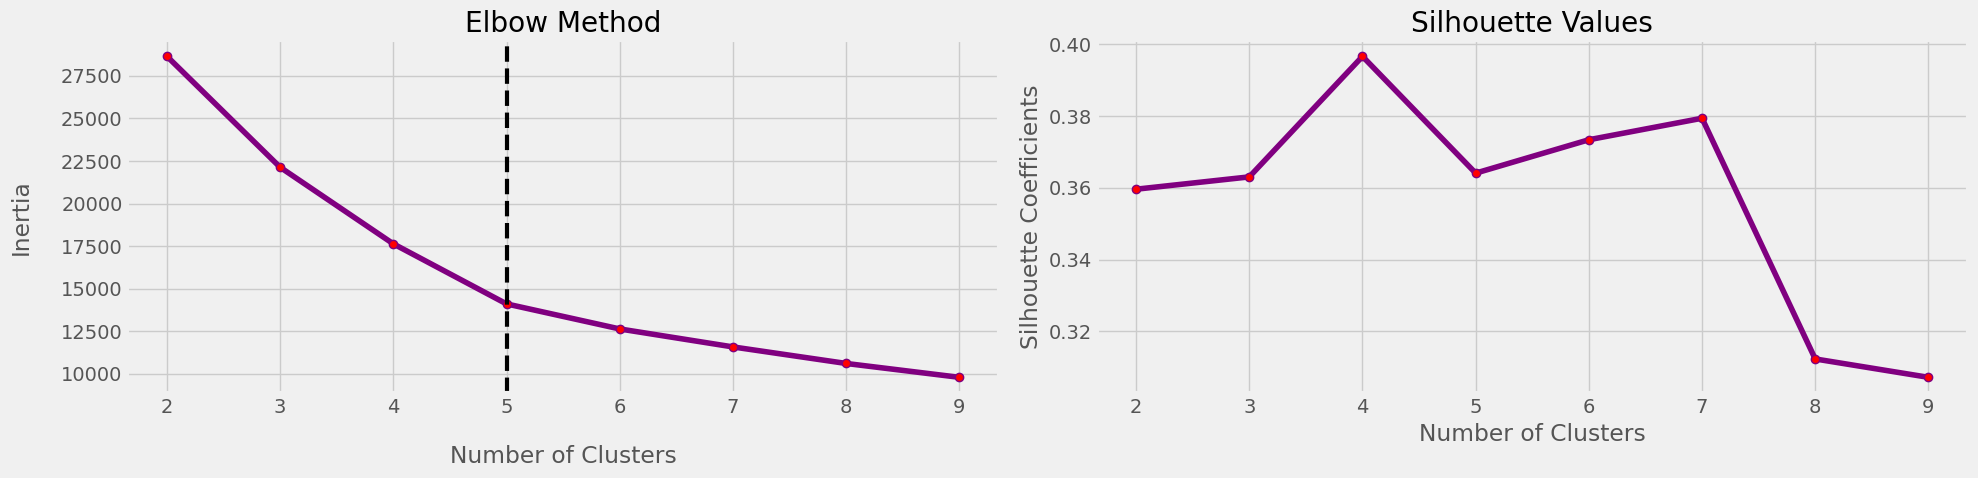

In [118]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

kl = KneeLocator(range(2, 10), inertias, curve='convex', direction="decreasing")

# Plot for Elbow Method
ax[0].plot(range(2, 10), inertias, color='purple', marker='o', linestyle='-', label='Elbow Method',markerfacecolor='red')
ax[0].set_xticks(range(2, 10))
ax[0].set_xlabel("Number of Clusters", labelpad=20)
ax[0].set_ylabel("Inertia", labelpad=20)
ax[0].set_title("Elbow Method")
ax[0].axvline(x=kl.elbow, color='black', label='axvline-fullheight', ls='--', linewidth=3)

# Plot for Silhouette Coefficients
ax[1].plot(range(2, 10), silhouette_coefficients, color='purple', marker='o', linestyle='-', label='Silhouette Coefficients', markerfacecolor='red')
ax[1].set_xticks(range(2, 10))
ax[1].set_title("Silhouette Values")
ax[1].set_xlabel("Number of Clusters")
ax[1].set_ylabel("Silhouette Coefficients")

plt.tight_layout()
plt.show()


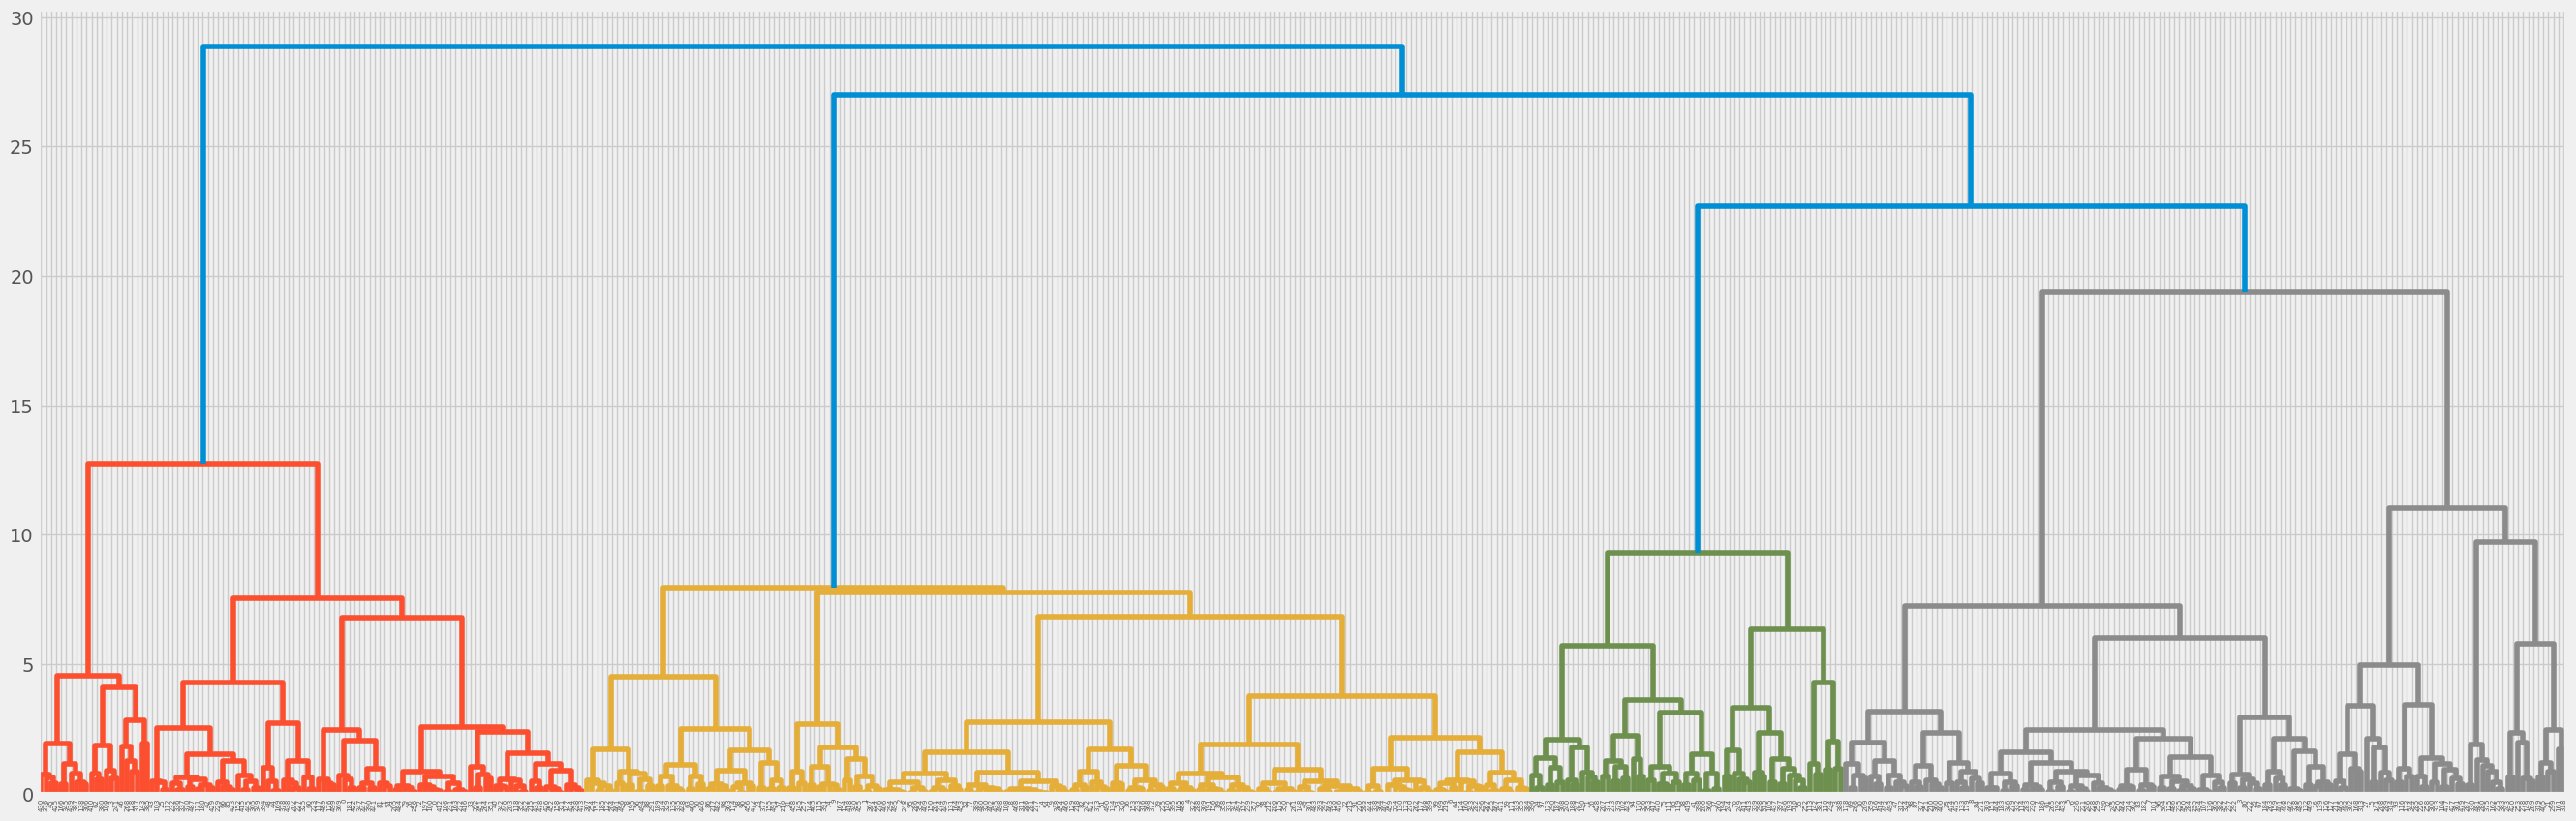

In [119]:
plt.figure(figsize=(30,10))
z = sch.linkage(RFM_scaled.iloc[:500,:], 'ward')
sch.dendrogram(z);

<p>The three charts ensure that the number of clustering is either 4 or 5 so I will use 5 for this project.</p>

In [120]:
kmeans = KMeans(n_clusters=5 , **kmeans_set)
kmeans.fit(RFM_scaled)
RFM_scaled['Cluster']=kmeans.labels_
RFM_scaled.head()

C:\Users\linco\AppData\Local\Temp\ipykernel_3024\1586373048.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Frequency,CustGender,CustAccountBalance,Monetary,CustomerAge,Recency,Cluster
0,0.0,-1.659201,0.751183,-0.947592,0.314562,2.414185,3
1,0.0,0.602700,0.277794,-0.911195,-1.039504,2.414185,0
2,0.0,0.602700,-0.789542,-0.909280,0.121124,2.414185,0
3,0.0,0.602700,0.432874,-0.857559,0.121124,2.414185,0
4,0.0,0.602700,-0.609992,-0.478269,-0.652628,2.414185,0


In [158]:
# Creating a target column "Cluster" for storing the cluster segment
df_segm = pd.concat([RFM_no_outliers.head(10000).reset_index(drop=True),pd.DataFrame({'Cluster':kmeans.labels_})],axis=1)
df_segm

,Frequency,CustGender,CustAccountBalance,Monetary,CustomerAge,Recency,Cluster
0,1,0,42829.91,5.0,30.0,306,3
1,1,1,29711.74,24.0,23.0,306,0
2,1,1,134.61,25.0,29.0,306,0
3,1,1,34009.18,52.0,29.0,306,0
4,1,1,5110.16,250.0,25.0,306,0
...,...,...,...,...,...,...,...
9995,1,1,16525.63,160.0,23.0,306,0
9996,1,1,19014.11,799.0,26.0,306,0
9997,1,1,57133.46,400.0,33.0,306,2
9998,1,1,4241.44,199.0,27.0,306,0


In [155]:
df_segm_analysis = df_segm.groupby(['Cluster']).mean().round(4)
df_segm_analysis

,Frequency,CustGender,CustAccountBalance,Monetary,CustomerAge,Recency
Cluster,,,,,,
0,1.0,1.0000,10668.8306,258.7114,25.4178,306.0
1,1.0,0.9878,15075.1092,397.4467,34.4571,306.0
2,1.0,0.7308,90023.5255,567.2340,30.7862,306.0
3,1.0,0.0000,16604.3656,375.8928,26.8234,306.0
4,1.0,0.7513,20122.8377,1600.9073,29.8640,306.0


C:\Users\linco\AppData\Local\Temp\ipykernel_3024\3126987351.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




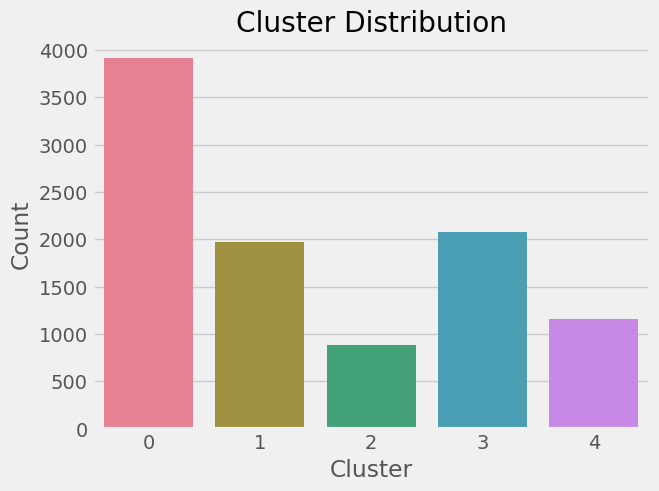

In [121]:
custom_palette = sns.color_palette("husl", n_colors=len(RFM_scaled['Cluster'].unique()))
sns.countplot(x='Cluster', data=RFM_scaled, palette=custom_palette)

plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


In [122]:
#sns.pairplot(df_scaled,hue='Label');

In [123]:
# Assuming 'Cluster' is a column in RFM_scaled DataFrame
RFM_scaled['Cluster'] = RFM_scaled['Cluster'].astype(int)

attributes = RFM_scaled.columns[:6]
colors = ['yellow', 'red', 'blue', 'magenta', 'orange']
cluster = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']

fig = go.Figure()

for index in range(5):
    cluster_data = RFM_scaled.loc[RFM_scaled['Cluster'] == index, attributes]
    mean_values = np.mean(cluster_data, axis=0)
    
    fig.add_trace(go.Scatterpolar(
        r=mean_values.values,  # Ensure 'r' is a NumPy array
        theta=attributes,
        fill='toself',
        name=cluster[index],
        line=dict(color=colors[index]),
        #opacity=0.3,
    ))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True)),
    showlegend=True,
    title="Radar plot - Cluster attributes (Normalized Values)"
)

fig.show()


C:\Users\linco\AppData\Local\Temp\ipykernel_3024\1138846336.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



*   All clusters has customers with highest Recency.
*   cluster4 has customers with highest Monetary.
*   cluster2 has customers with highest Customer Account Balance.




<p></p>

### PCA

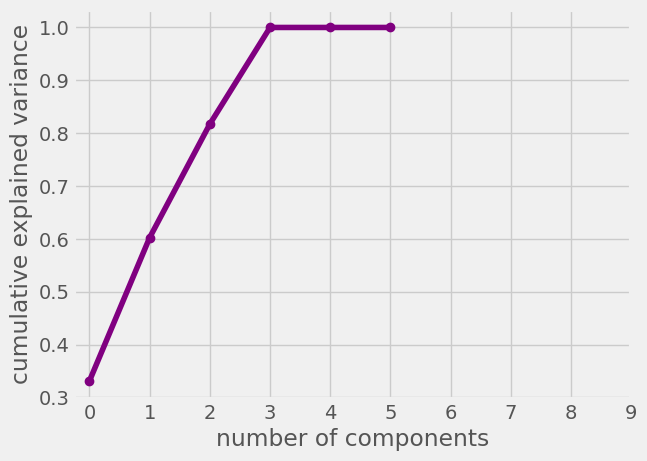

In [124]:
# here we want to check how many component we need to explain 70-80%  of the variance
plt.style.use("fivethirtyeight")
RFM = RFM_scaled.iloc[:,:-1]
pca = PCA().fit(RFM)
plt.plot(np.cumsum(pca.explained_variance_ratio_),color='purple',marker='o')  #EX: cusum([4,2,3,1,6]) ==>[4,6,9,10,16]
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
# x tickes
plt.xticks(np.arange(0, 10, 1))
plt.show();

In [125]:
# I will take 2 components as it explains 80% of variance
pca = PCA(n_components=2)
pca_data = pca.fit(RFM)

df_pca_components = pd.DataFrame(
    data=pca_data.components_.round(4),
    columns=RFM.columns.values,
    index=['PCA 1', 'PCA 2'])

df_pca_components

,Frequency,CustGender,CustAccountBalance,Monetary,CustomerAge,Recency
PCA 1,0.0,-0.0568,0.5401,0.5988,0.5886,-0.0
PCA 2,-0.0,-0.9060,0.1974,0.0926,-0.3627,-0.0


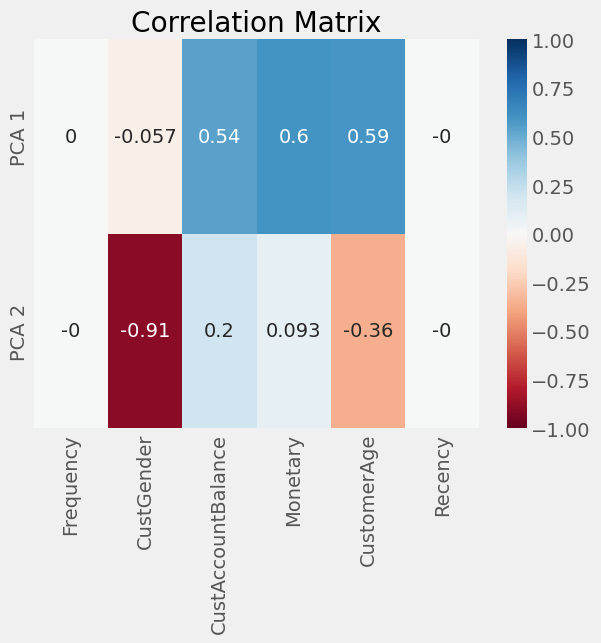

In [126]:
s = sns.heatmap(
    df_pca_components,
    vmin=-1,
    vmax=1,
    cmap='RdBu',
    annot=True
)
plt.title('Correlation Matrix')
plt.show()

PCA 1 has a positive correlation with Customer Account Balance, Monetary, and Age. These features are related to how much money a customer have in the bank.

On the other hand, PCA 2 has a negative correlation with Age, Customer Gender. These features are related to sex and lifestyle of a customer.

### Implementing K-Means Clustering with PCA

In [127]:
inertia = []
silhouette = []
pca_data = pca_data.transform(RFM)

for k in range(2,11):
    km = KMeans(init='k-means++', n_clusters=k, random_state=42)
    km.fit(pca_data)
    inertia.append(km.inertia_)
    P_score=silhouette_score(pca_data, km.labels_)
    silhouette.append(P_score)

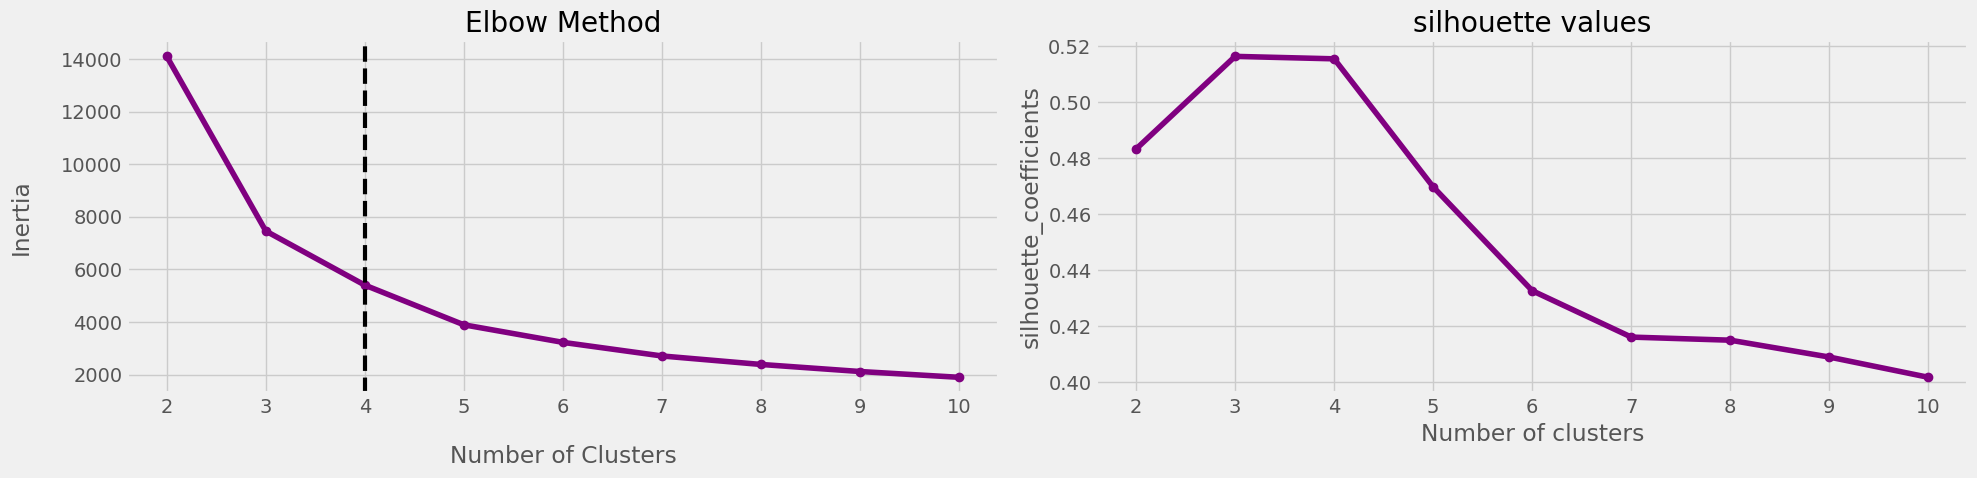

In [128]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(1,2,figsize=(20,5))
Pkl = KneeLocator(range(2,11), inertia, curve='convex', direction="decreasing")
# draw Elbow
ax[0].plot(range(2,11), inertia,color='purple',marker='o',label='Elbow Method')
ax[0].set_xticks(range(2,11))
ax[0].set_xlabel("Number of Clusters", labelpad=20)
ax[0].set_ylabel("Inertia", labelpad=20)
ax[0].set_title("Elbow Method")
ax[0].axvline(x=Pkl.elbow, color='black', label='axvline-fullheight', ls='--', linewidth=3)
# draw silhouette
ax[1].plot(range(2,11), silhouette,color='purple',marker='o',label='silhouette coefficients')
ax[1].set_xticks(range(2,11))
ax[1].set_title("silhouette values")
ax[1].set_xlabel("Number of clusters")
ax[1].set_ylabel("silhouette_coefficients")
plt.tight_layout();

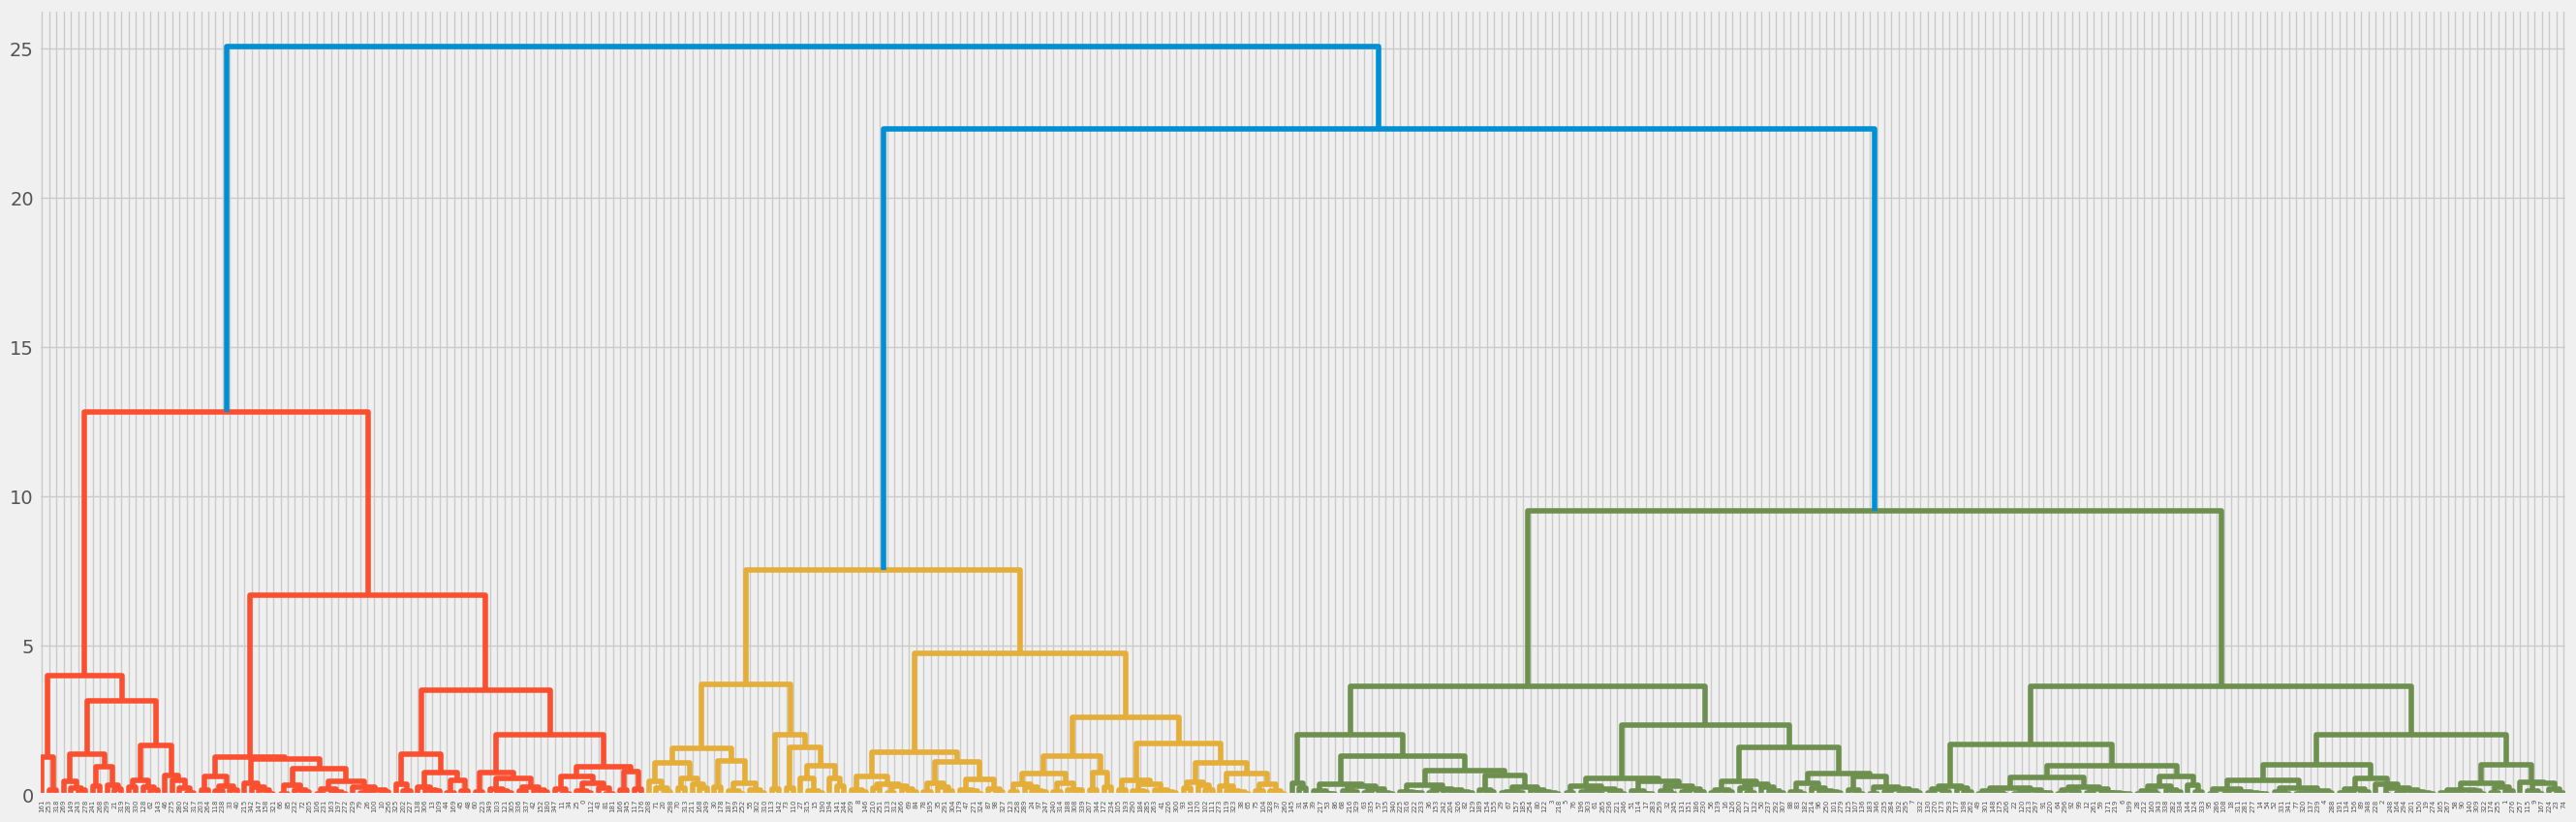

In [129]:
plt.figure(figsize=(30,10))
z = sch.linkage(pca_data[:350,:], 'ward')
sch.dendrogram(z);

<p>the three charts insure that the number of clustering is 4 so I will use it</p>

In [144]:
PCA_kmeans = KMeans(n_clusters=4 , **kmeans_set)
PCA_kmeans.fit(pca_data)
# create a dataframe for the pca data
rfm = RFM_no_outliers.head(10000)
df_segm_pca = pd.concat([rfm.reset_index(drop=True), pd.DataFrame(pca_data)], axis=1)
df_segm_pca.columns.values[-2:] = ['PCA 1', 'PCA 2']
df_segm_pca['Cluster'] = PCA_kmeans.labels_

df_segm_pca

,Frequency,CustGender,CustAccountBalance,Monetary,CustomerAge,Recency,PCA 1,PCA 2,Cluster
0,1,0,42829.91,5.0,30.0,306,0.136436,1.474199,3
1,1,1,29711.74,24.0,23.0,306,-1.022903,-0.174088,0
2,1,1,134.61,25.0,29.0,306,-0.915045,-0.805610,0
3,1,1,34009.18,52.0,29.0,306,-0.223840,-0.559487,0
4,1,1,5110.16,250.0,25.0,306,-1.015432,-0.449600,0
...,...,...,...,...,...,...,...,...,...
9995,1,1,16525.63,160.0,23.0,306,-1.123904,-0.243909,0
9996,1,1,19014.11,799.0,26.0,306,-0.000825,-0.323331,0
9997,1,1,57133.46,400.0,33.0,306,1.081506,-0.613670,1
9998,1,1,4241.44,199.0,27.0,306,-0.863137,-0.605162,0


In [145]:
df_segm_pca_analysis = df_segm_pca.groupby(['Cluster']).mean().round(4)
df_segm_pca_analysis

,Frequency,CustGender,CustAccountBalance,Monetary,CustomerAge,Recency,PCA 1,PCA 2
Cluster,,,,,,,,
0,1.0,1.0000,10457.7578,266.0509,26.5978,306.0,-0.7109,-0.5208
1,1.0,0.9984,36212.9880,875.3443,33.1011,306.0,1.2307,-0.6822
2,1.0,0.0378,48325.5614,1005.0438,30.9689,306.0,1.4961,1.5452
3,1.0,0.0011,13978.0007,316.0242,25.8801,306.0,-0.5384,1.6106


From above result, we can say that:

* Cluster 0: Low value customers as they have lowest Balance and Monetary value.
* Cluster 2: High value customers as they have highest Balance and Monetary value.

In [132]:
#sns.pairplot(pca_df,hue='label');

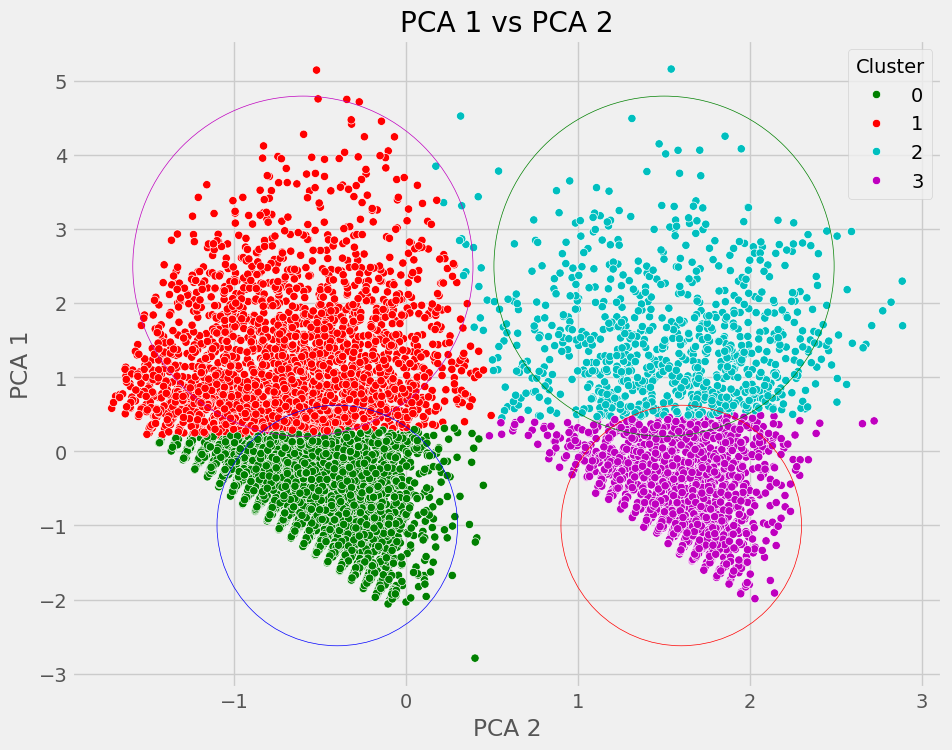

In [190]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=df_segm_pca['PCA 2'],
    y=df_segm_pca['PCA 1'],
    hue=df_segm_pca['Cluster'],
    palette=['g','r','c','m']
)
plt.scatter(1.5, 2.5 , s=60000, facecolors='none', edgecolors='g' )
plt.scatter(-0.6, 2.5 , s=60000, facecolors='none', edgecolors='m' )
plt.scatter(-0.4, -1 , s=30000, facecolors='none', edgecolors='b' )
plt.scatter(1.6, -1 , s=30000, facecolors='none', edgecolors='r' )

plt.title('PCA 1 vs PCA 2')
plt.show()

In [148]:
pca_df = df_segm_pca[['PCA 1', 'PCA 2', 'Cluster']]

pca_df['Cluster'] = pca_df['Cluster'].astype(int)

attributes = pca_df.columns[:2]
colors = ['yellow', 'red', 'blue', 'magenta']
cluster = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']

fig = go.Figure()

for index in range(4):
    cluster_data = pca_df.loc[pca_df['Cluster'] == index, attributes]
    mean_values = np.mean(cluster_data, axis=0)
    
    fig.add_trace(go.Scatterpolar(
        r=mean_values.values,  # Ensure 'r' is a NumPy array
        theta=attributes,
        fill='toself',
        name=cluster[index],
        line=dict(color=colors[index]),
        #opacity=0.3,
    ))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True)),
    showlegend=True,
    title="Radar plot - Cluster attributes (Normalized Values)"
)

fig.show()

C:\Users\linco\AppData\Local\Temp\ipykernel_3024\1220637132.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



I will go ahead without PCA. and Then I will save the k means model with n_cluster = 5 and data for classification problem.

### Saving the kmeans clustering model and the data with cluster label

In [159]:
#Saving Scikitlearn models
import joblib
joblib.dump(kmeans, "kmeans_model.pkl")

['kmeans_model.pkl']

In [160]:
df_segm.to_csv("Clustered_Customer_Data.csv")

### 7. Classification using decision tree

In [162]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn import metrics

In [163]:
#Split Dataset
x = df_segm.drop(['Cluster'],axis=1)
y= df_segm[['Cluster']]
x_train, x_test, y_train, y_test =train_test_split(x, y, test_size=0.1, stratify=y,random_state=42)

### 8. Modelling for Classification

In [167]:
model= DecisionTreeClassifier(criterion="entropy")
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [165]:
#Confusion_Matrix
print(metrics.confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[390   1   0   0   0]
 [  1 195   1   0   0]
 [  0   2  86   1   0]
 [  0   0   0 206   2]
 [  1   0   4   0 110]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       391
           1       0.98      0.99      0.99       197
           2       0.95      0.97      0.96        89
           3       1.00      0.99      0.99       208
           4       0.98      0.96      0.97       115

    accuracy                           0.99      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.99      0.99      0.99      1000



In [166]:
import pickle
filename = 'final_model.sav'
pickle.dump(model, open(filename, 'wb'))

<p></p>